<center>
    <h1>Rotten vs Fresh Fruit Detection</h1>
</center>

In [6]:
# Data Manipulation
import numpy as np
import pandas as pd
# Visualisation
import matplotlib.pyplot as plt
# Dataset exploring
import os

## Libraries

In [7]:

# Dataset generation
from keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
# Transfert learning
from keras.applications import VGG16
# Optimizer
from keras.optimizers import Adam
# Keras layers
from keras.layers import Input, Dense, Dropout, Flatten, AveragePooling2D
# Keras model
from keras.models import Model

## Exploring data

In [8]:
classes = []
class_counter = 0

for dirname, _, filenames in os.walk('/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/train/'):
    if dirname.endswith('/'):
        continue
    else:
        classes.append({dirname.split('/')[-1]: 0})
    file_count = 0
    for filename in filenames:
        file_count += 1
    classes[class_counter][dirname.split('/')[-1]] = file_count
    class_counter += 1
    
print('{:<15} {:<15}'.format('Class', 'Number of instances'))
print()
for d in classes:
    [(k, v)] = d.items()
    print('{:<15} {:<15}'.format(k, v))

Class           Number of instances

rottenbanana    2224           
freshoranges    1466           
rottenoranges   1595           
freshbanana     1581           
rottenapples    2342           
freshapples     1693           


In [30]:
import os

# Initialize classes and counters
classes = []
class_counter = 0

# Walk through the dataset directory
for dirname, _, filenames in os.walk('/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/train/'):
    if dirname.endswith('/'):
        continue
    else:
        # Filter only 'freshapples' and 'rottenapples'
        class_name = dirname.split('/')[-1]
        if class_name in ['freshapples', 'rottenapples']:
            classes.append({class_name: 0})
            
            file_count = len(filenames)  # Count the number of files
            classes[class_counter][class_name] = file_count
            class_counter += 1

# Print header
print('{:<15} {:<15}'.format('Class', 'Number of instances'))
print()

# Print values for 'freshapples' and 'rottenapples'
for d in classes:
    [(k, v)] = d.items()
    print('{:<15} {:<15}'.format(k, v))
#Training dataset number 

Class           Number of instances

rottenapples    2342           
freshapples     1693           


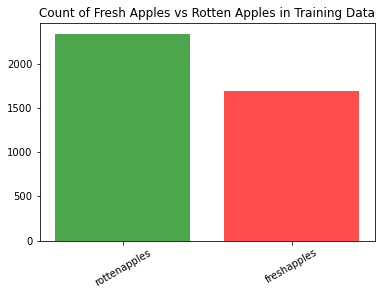

In [31]:
import matplotlib.pyplot as plt

# Initialize lists to store counts and labels for only 'freshapples' and 'rottenapples'
counts = []
labels = []

# Filter only 'freshapples' and 'rottenapples'
for d in classes:
    [(k, v)] = d.items()
    if k in ['freshapples', 'rottenapples']:
        labels.append(k)
        counts.append(v)

# Plotting the bar chart for only 'freshapples' and 'rottenapples'
plt.figure()
plt.bar(range(len(counts)), counts, color=['green', 'red'], alpha=0.7)
plt.xticks(range(len(counts)), labels, rotation=30)
plt.title('Count of Fresh Apples vs Rotten Apples in Training Data')
plt.show()


We may have a slight imbalance in our dataset. Orange images are much less than apples.

## Loading data

In [10]:
TRAIN_PATH = '/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/train'
TEST_PATH = '/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/test'

To generate more images we will use Keras' `ImageDataGenerator`.

In [11]:
datagen = ImageDataGenerator(
    rotation_range = 30, 
    zoom_range = .3, 
    horizontal_flip = True, 
    vertical_flip = True, 
    validation_split = .3
)

train_ds = datagen.flow_from_directory(
    directory = TRAIN_PATH,
    target_size = (256, 256),
    color_mode = 'rgb',
    class_mode = 'categorical',
    subset = 'training'
)

validation_ds = datagen.flow_from_directory(
    directory = TRAIN_PATH,
    target_size = (256, 256),
    color_mode = 'rgb',
    class_mode = 'categorical',
    subset = 'validation'
)

Found 7634 images belonging to 6 classes.
Found 3267 images belonging to 6 classes.


## Creating model architecture
Note : We will be using VGG-16 for transfert learning

In [12]:
vgg16 = VGG16(include_top = False, weights = 'imagenet', input_shape = (224, 224, 3))
vgg16.trainable = False

58892288/58889256 [==============================] - 2s 0us/step


In [13]:
X_input = Input(shape = (256, 256, 3))
X = vgg16(X_input)
X = AveragePooling2D(pool_size = (3, 3), strides = 2, padding = 'valid',name = 'AvgPool2D')(X)
X = Flatten(name = 'Flatten')(X)
X = Dense(200, activation = 'relu', name = 'Dense1')(X)
X = Dropout(.1)(X)
X = Dense(100, activation = 'relu', name = 'Dense2')(X)
X = Dropout(.1)(X)
X = Dense(6, activation = 'softmax', name = 'Dense3')(X)

model = Model(inputs = X_input, outputs = X, name = 'Fruit_Classifer')

print(model.summary())

Model: "Fruit_Classifer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
AvgPool2D (AveragePooling2D) (None, 3, 3, 512)         0         
_________________________________________________________________
Flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
Dense1 (Dense)               (None, 200)               921800    
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
Dense2 (Dense)               (None, 100)           

In [14]:
optimizer = Adam(learning_rate = 0.001)

model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

hist = model.fit(train_ds, validation_data = validation_ds, epochs = 8, batch_size = 32)

Epoch 1/8
239/239 [==============================] - 267s 1s/step - loss: 0.9820 - accuracy: 0.8263 - val_loss: 0.2725 - val_accuracy: 0.9324
Epoch 2/8
239/239 [==============================] - 198s 827ms/step - loss: 0.2985 - accuracy: 0.9138 - val_loss: 0.1480 - val_accuracy: 0.9565
Epoch 3/8
239/239 [==============================] - 195s 816ms/step - loss: 0.2356 - accuracy: 0.9315 - val_loss: 0.0740 - val_accuracy: 0.9780
Epoch 4/8
239/239 [==============================] - 197s 826ms/step - loss: 0.1717 - accuracy: 0.9471 - val_loss: 0.1114 - val_accuracy: 0.9633
Epoch 5/8
239/239 [==============================] - 196s 821ms/step - loss: 0.1500 - accuracy: 0.9531 - val_loss: 0.0661 - val_accuracy: 0.9783
Epoch 6/8
239/239 [==============================] - 196s 822ms/step - loss: 0.1311 - accuracy: 0.9561 - val_loss: 0.0365 - val_accuracy: 0.9856
Epoch 7/8
239/239 [==============================] - 196s 822ms/step - loss: 0.1197 - accuracy: 0.9576 - val_loss: 0.0564 - val_accur

## Model evaluation using test data

In [15]:
test_ds = image_dataset_from_directory(
    TEST_PATH,
    label_mode = 'categorical',
    color_mode = 'rgb',
    image_size = (256, 256)
)

Found 2698 files belonging to 6 classes.


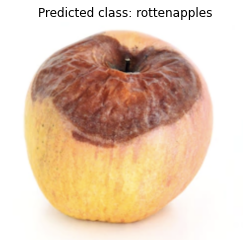

Predicted class: rottenapples
Predicted probabilities: [3.5503348e-08 3.8472512e-22 1.9311907e-18 1.0000000e+00 1.3006281e-16
 1.9904853e-09]


In [33]:
new_image_path ='/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/test/rottenapples/Screen Shot 2018-06-07 at 2.22.39 PM.png'
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

 
# Load the new image
img = image.load_img(new_image_path, target_size=(256, 256))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Make predictions
predictions = model.predict(img_array)

# Get the predicted class index
predicted_class_index = np.argmax(predictions)

# Get the class label
class_labels = list(train_ds.class_indices.keys())
predicted_class_label = class_labels[predicted_class_index]

# Display the image
img = mpimg.imread(new_image_path)
plt.imshow(img)
plt.axis('off')
plt.title(f'Predicted class: {predicted_class_label}')
plt.show()

# Print the results
print(f'Predicted class: {predicted_class_label}')
print(f'Predicted probabilities: {predictions[0]}')


In [35]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Load the test data for freshapples and rottenapples
test_datagen = image.ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/test/',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Filter only freshapples and rottenapples class indices
class_labels = list(test_generator.class_indices.keys())
filtered_classes = ['freshapples', 'rottenapples']
filtered_indices = [test_generator.class_indices[cls] for cls in filtered_classes]

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Accuracy: {test_acc:.4f}")

# Make predictions on the test data
predictions = model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Filter predictions and true labels to only include freshapples and rottenapples
y_true_filtered = [y for i, y in enumerate(y_true) if y in filtered_indices]
y_pred_filtered = [y for i, y in enumerate(y_pred) if y_true[i] in filtered_indices]

# Get the filtered class labels for reporting
filtered_class_labels = [class_labels[i] for i in filtered_indices]

# Print the classification report only for freshapples and rottenapples
print("Classification Report for freshapples and rottenapples:")
print(classification_report(y_true_filtered, y_pred_filtered, target_names=filtered_class_labels))

# Confusion matrix for freshapples and rottenapples
cm = confusion_matrix(y_true_filtered, y_pred_filtered)
print("Confusion Matrix:")
print(cm)


Found 2698 images belonging to 6 classes.
85/85 [==============================] - 17s 205ms/step - loss: 0.4012 - accuracy: 0.9103
Test Accuracy: 0.9103
Classification Report for freshapples and rottenapples:


ValueError: Number of classes, 5, does not match size of target_names, 2. Try specifying the labels parameter

In [36]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Load the test data for freshapples and rottenapples
test_datagen = image.ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/test/',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Filter only freshapples and rottenapples class indices
class_labels = list(test_generator.class_indices.keys())
filtered_classes = ['freshapples', 'rottenapples']
filtered_indices = [test_generator.class_indices[cls] for cls in filtered_classes]

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Accuracy: {test_acc:.4f}")

# Make predictions on the test data
predictions = model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Filter predictions and true labels to only include freshapples and rottenapples
y_true_filtered = [y for i, y in enumerate(y_true) if y in filtered_indices]
y_pred_filtered = [y for i, y in enumerate(y_pred) if y_true[i] in filtered_indices]

# Get the filtered class labels for reporting
filtered_class_labels = [class_labels[i] for i in filtered_indices]

# Specify the filtered indices as the labels parameter in classification report
print("Classification Report for freshapples and rottenapples:")
print(classification_report(y_true_filtered, y_pred_filtered, labels=filtered_indices, target_names=filtered_class_labels))

# Confusion matrix for freshapples and rottenapples
cm = confusion_matrix(y_true_filtered, y_pred_filtered, labels=filtered_indices)
print("Confusion Matrix:")
print(cm)


Found 2698 images belonging to 6 classes.
85/85 [==============================] - 17s 204ms/step - loss: 0.4012 - accuracy: 0.9103
Test Accuracy: 0.9103
Classification Report for freshapples and rottenapples:
              precision    recall  f1-score   support

 freshapples       0.99      0.96      0.98       395
rottenapples       0.98      0.99      0.98       601

   micro avg       0.98      0.98      0.98       996
   macro avg       0.99      0.97      0.98       996
weighted avg       0.98      0.98      0.98       996

Confusion Matrix:
[[379  13]
 [  3 593]]


In [40]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Load the test data for freshapples and rottenapples
test_datagen = image.ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/real-apple-customdataset2/freshapple_custom',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Filter only freshapples and rottenapples class indices
class_labels = list(test_generator.class_indices.keys())
filtered_classes = ['freshapples', 'rottenapples']
filtered_indices = [test_generator.class_indices[cls] for cls in filtered_classes]

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Accuracy: {test_acc:.4f}")

# Make predictions on the test data
predictions = model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Filter predictions and true labels to only include freshapples and rottenapples
y_true_filtered = [y for i, y in enumerate(y_true) if y in filtered_indices]
y_pred_filtered = [y for i, y in enumerate(y_pred) if y_true[i] in filtered_indices]

# Get the filtered class labels for reporting
filtered_class_labels = [class_labels[i] for i in filtered_indices]

# Specify the filtered indices as the labels parameter in classification report
print("Classification Report for freshapples and rottenapples:")
print(classification_report(y_true_filtered, y_pred_filtered, labels=filtered_indices, target_names=filtered_class_labels))

# Confusion matrix for freshapples and rottenapples
cm = confusion_matrix(y_true_filtered, y_pred_filtered, labels=filtered_indices)
print("Confusion Matrix:")
print(cm)


Found 0 images belonging to 0 classes.


KeyError: 'freshapples'

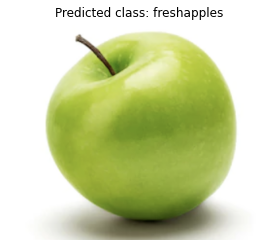

Predicted class: freshapples
Predicted probabilities: [9.9999988e-01 3.3042530e-13 9.6128627e-10 1.6160786e-07 4.4166068e-20
 7.3788940e-13]


In [19]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Replace 'path_to_new_image.jpg' with the path to your new image
new_image_path ='/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/test/freshapples/Screen Shot 2018-06-08 at 4.59.44 PM.png'

# Load the new image
img = image.load_img(new_image_path, target_size=(256, 256))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Make predictions
predictions = model.predict(img_array)

# Get the predicted class index
predicted_class_index = np.argmax(predictions)

# Get the class label
class_labels = list(train_ds.class_indices.keys())
predicted_class_label = class_labels[predicted_class_index]

# Display the image
img = mpimg.imread(new_image_path)
plt.imshow(img)
plt.axis('off')
plt.title(f'Predicted class: {predicted_class_label}')
plt.show()

# Print the results
print(f'Predicted class: {predicted_class_label}')
print(f'Predicted probabilities: {predictions[0]}')


In [47]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Filter class indices to only include freshapples and rottenapples
class_labels = list(train_ds.class_indices.keys())
target_classes = ['freshapples', 'rottenapples']
class_indices = [class_labels.index(label) for label in target_classes]

# Filter the test dataset to include only the target classes
test_images_filtered = []
test_labels_filtered = []

for image, label in zip(test_images, test_labels):
    if np.argmax(label) in class_indices:
        test_images_filtered.append(image)
        test_labels_filtered.append(label)

# Convert lists to arrays
test_images_filtered = np.array(test_images_filtered)
test_labels_filtered = np.array(test_labels_filtered)

# Predict on the filtered dataset
test_predictions = model.predict(test_images_filtered)
test_predictions = np.argmax(test_predictions, axis=1)

# Get true labels
true_labels = np.argmax(test_labels_filtered, axis=1)

# Print classification report and confusion matrix for the filtered classes
print("Classification Report:")
print(classification_report(true_labels, test_predictions, target_names=target_classes))

print("Confusion Matrix:")
print(confusion_matrix(true_labels, test_predictions, labels=class_indices))



Classification Report:
              precision    recall  f1-score   support

 freshapples       1.00      1.00      1.00         7
rottenapples       1.00      1.00      1.00         2

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9

Confusion Matrix:
[[7 0]
 [0 2]]


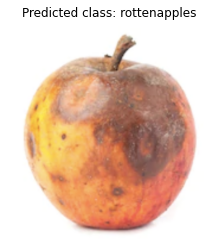

Predicted class: rottenapples
Predicted probabilities: [2.3452776e-04 7.7921447e-11 2.5676554e-08 9.9854785e-01 3.1663461e-08
 1.2176386e-03]


In [21]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Replace 'path_to_new_image.jpg' with the path to your new image
new_image_path = '/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/test/rottenapples/Screen Shot 2018-06-07 at 2.15.34 PM.png'


# Load the new image
img = image.load_img(new_image_path, target_size=(256, 256))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Make predictions
predictions = model.predict(img_array)

# Get the predicted class index
predicted_class_index = np.argmax(predictions)

# Get the class label
class_labels = list(train_ds.class_indices.keys())
predicted_class_label = class_labels[predicted_class_index]

# Display the image
img = mpimg.imread(new_image_path)
plt.imshow(img)
plt.axis('off')
plt.title(f'Predicted class: {predicted_class_label}')
plt.show()

# Print the results
print(f'Predicted class: {predicted_class_label}')
print(f'Predicted probabilities: {predictions[0]}')


# Model Evaluation

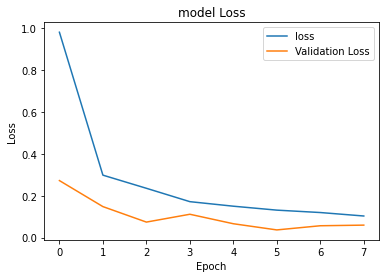

In [22]:
import matplotlib.pyplot as plt
 
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["loss","Validation Loss"])
plt.show()

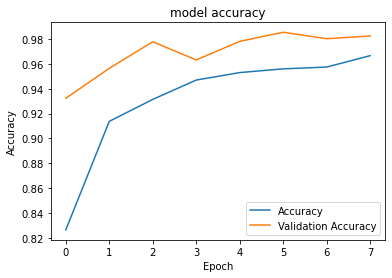

In [23]:
import matplotlib.pyplot as plt
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

In [24]:
results = model.evaluate(test_ds)

print('{:<20} {:<20}'.format('Test loss', 'Test accuracy'))
print('{:<20} {:<20}'.format(np.round(results[0], 2), np.round(results[1], 2)))

85/85 [==============================] - 31s 367ms/step - loss: 0.0555 - accuracy: 0.9807
Test loss            Test accuracy       
0.06                 0.98                


# Visualizations of Findings

Found 2698 images belonging to 6 classes.
Classification Report:
                precision    recall  f1-score   support

  freshapples       0.91      0.43      0.58       395
  freshbanana       0.86      0.23      0.37       381
 freshoranges       0.81      0.62      0.70       388
 rottenapples       0.61      0.91      0.73       601
 rottenbanana       0.58      0.86      0.69       530
rottenoranges       0.73      0.78      0.75       403

     accuracy                           0.67      2698
    macro avg       0.75      0.64      0.64      2698
 weighted avg       0.73      0.67      0.65      2698



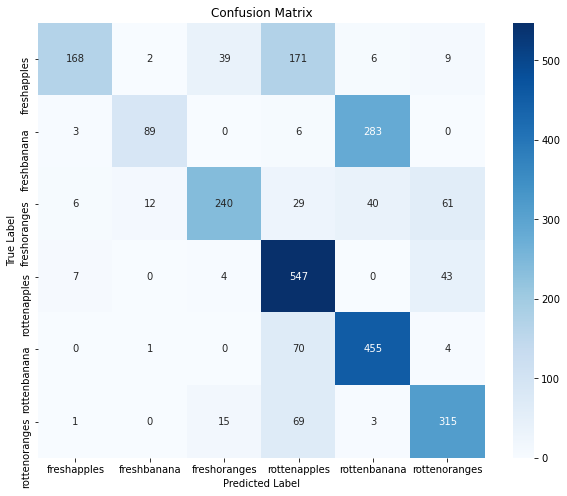

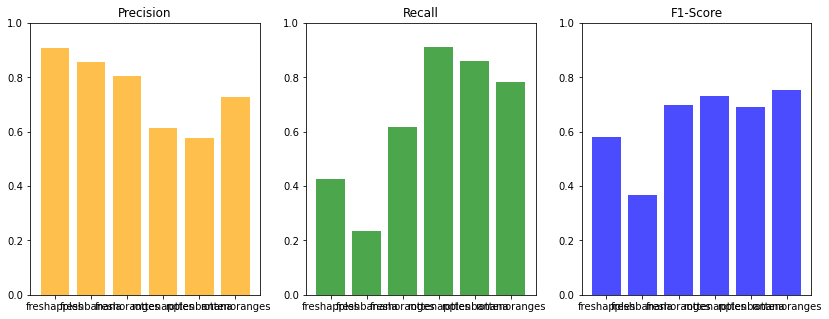

In [25]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
# Data preparation for test set
test_datagen = ImageDataGenerator(
    rescale=1./255
)

# Generate predictions for the entire test set
test_generator = test_datagen.flow_from_directory(
    directory=TEST_PATH,
    target_size=(256, 256),
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False
)

# Get true labels
true_labels = test_generator.classes

# Make predictions
predictions = model.predict(test_generator)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Display classification report
class_names = list(test_generator.class_indices.keys())
classification_rep = classification_report(true_labels, predicted_labels, target_names=class_names)
print("Classification Report:\n", classification_rep)

# Visualize confusion matrix using seaborn
plt.figure(figsize=(10, 8))

# Heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Visualize precision, recall, and F1-score
precision = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
recall = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
f1_score = 2 * (precision * recall) / (precision + recall)

# Bar plots
plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.bar(class_names, precision, color='orange', alpha=0.7)
plt.title('Precision')
plt.ylim(0, 1)

plt.subplot(1, 3, 2)
plt.bar(class_names, recall, color='green', alpha=0.7)
plt.title('Recall')
plt.ylim(0, 1)

plt.subplot(1, 3, 3)
plt.bar(class_names, f1_score, color='blue', alpha=0.7)
plt.title('F1-Score')
plt.ylim(0, 1)

plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Assume `train_ds`, `test_images`, `test_labels`, and `model` are defined elsewhere

# Filter class indices to only include freshapples and rottenapples
class_labels = list(train_ds.class_indices.keys())
target_classes = ['freshapples', 'rottenapples']
class_indices = [class_labels.index(label) for label in target_classes]

# Filter the test dataset to include only the target classes
test_images_filtered = []
test_labels_filtered = []

for image, label in zip(test_images, test_labels):
    if np.argmax(label) in class_indices:
        test_images_filtered.append(image)
        test_labels_filtered.append(label)

# Convert lists to arrays
test_images_filtered = np.array(test_images_filtered)
test_labels_filtered = np.array(test_labels_filtered)

# Predict on the filtered dataset
test_predictions = model.predict(test_images_filtered)
test_predictions = np.argmax(test_predictions, axis=1)

# Get true labels
true_labels = np.argmax(test_labels_filtered, axis=1)

# Print classification report for freshapples and rottenapples
print("Classification Report:")
print(classification_report(true_labels, test_predictions, target_names=target_classes))

# Calculate confusion matrix for freshapples and rottenapples
conf_matrix = confusion_matrix(true_labels, test_predictions, labels=class_indices)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_classes, yticklabels=target_classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Fresh Apples and Rotten Apples')
plt.show()

# Plot histograms of true and predicted labels
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(true_labels, bins=np.arange(len(target_classes) + 1) - 0.5, edgecolor='k', align='mid')
plt.xticks(range(len(target_classes)), target_classes)
plt.xlabel('True Labels')
plt.ylabel('Frequency')
plt.title('Histogram of True Labels')

plt.subplot(1, 2, 2)
plt.hist(test_predictions, bins=np.arange(len(target_classes) + 1) - 0.5, edgecolor='k', align='mid')
plt.xticks(range(len(target_classes)), target_classes)
plt.xlabel('Predicted Labels')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Labels')

plt.tight_layout()
plt.show()


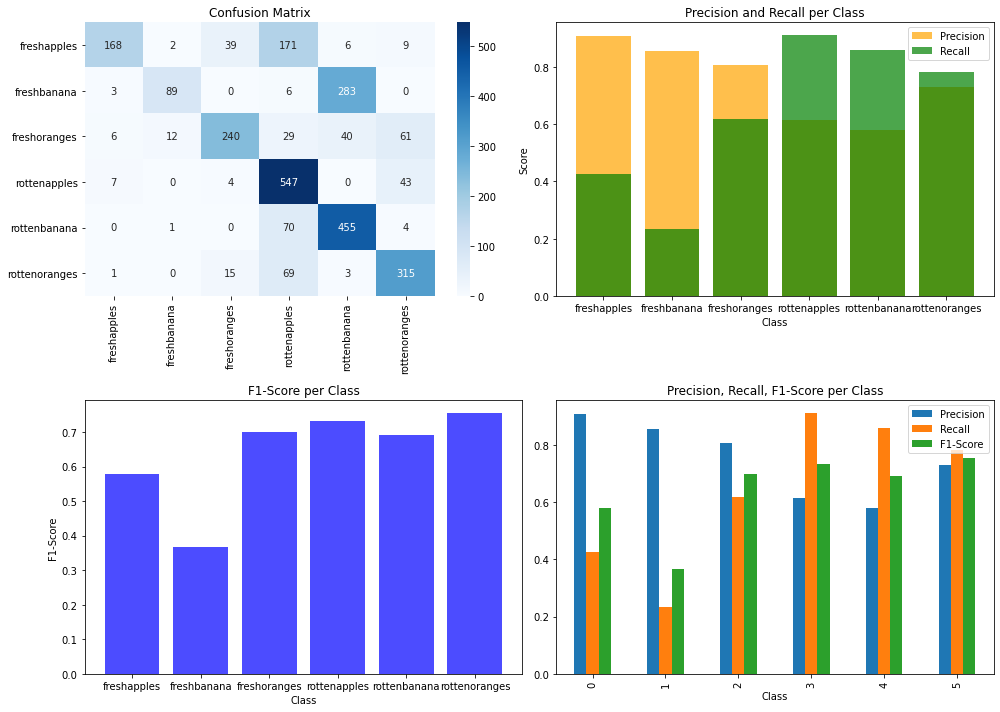

In [26]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_fscore_support

# Convert class labels to integers
label_encoder = LabelEncoder()
true_labels_encoded = label_encoder.fit_transform(true_labels)
predicted_labels_encoded = label_encoder.transform(predicted_labels)

# Get precision, recall, and F1-Score for each class
precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels_encoded, predicted_labels_encoded, average=None)

# Set up the matplotlib figure
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Confusion Matrix Heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axes[0, 0])
axes[0, 0].set_title('Confusion Matrix')

# Precision-Recall per Class
axes[0, 1].bar(class_names, precision, color='orange', alpha=0.7, label='Precision')
axes[0, 1].bar(class_names, recall, color='green', alpha=0.7, label='Recall')
axes[0, 1].set_xlabel('Class')
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_title('Precision and Recall per Class')
axes[0, 1].legend()

# F1-Score per Class
axes[1, 0].bar(class_names, f1_score, color='blue', alpha=0.7)
axes[1, 0].set_xlabel('Class')
axes[1, 0].set_ylabel('F1-Score')
axes[1, 0].set_title('F1-Score per Class')

# Bar plot for Precision, Recall, F1-Score
metrics_df = pd.DataFrame({'Precision': precision, 'Recall': recall, 'F1-Score': f1_score})
metrics_df.index.name = 'Class'

metrics_df.plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title('Precision, Recall, F1-Score per Class')

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# ROC Curve
y_bin = label_binarize(true_labels_encoded, classes=np.unique(true_labels_encoded))
n_classes = len(class_names)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(12, 8))

# Combined ROC Curve
for i in range(n_classes):
    ax.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Combined ROC Curve')
ax.legend()

# Feature Importance (Assuming model has attribute `feature_importances_`)
if hasattr(model, 'feature_importances_'):
    feature_importance = model.feature_importances_
    features = range(len(feature_importance))

    # Create an inset axis for the feature importance bar plot
    inset_ax = fig.add_axes([0.6, 0.6, 0.25, 0.25])
    inset_ax.bar(features, feature_importance, color='teal', alpha=0.7)
    inset_ax.set_xlabel('Feature Index')
    inset_ax.set_ylabel('Importance')
    inset_ax.set_title('Feature Importance')

plt.show()


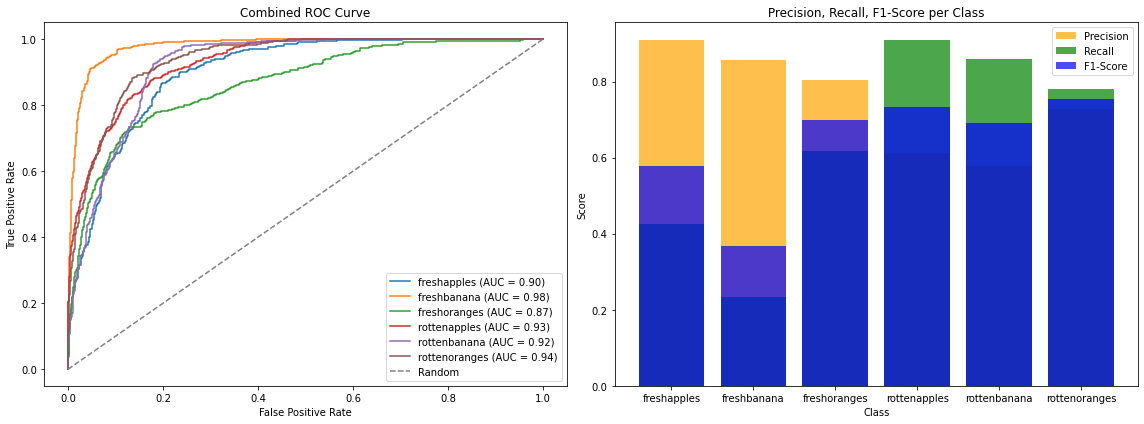

In [28]:
from sklearn.metrics import precision_recall_curve, auc, precision_recall_fscore_support
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Precision-Recall Curve
precision = dict()
recall = dict()
pr_auc = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_bin[:, i], predictions[:, i])
    pr_auc[i] = auc(recall[i], precision[i])

# Precision, Recall, F1-Score per Class
precision_per_class, recall_per_class, f1_score_per_class, _ = precision_recall_fscore_support(true_labels_encoded, predicted_labels_encoded, average=None)

# Set up the matplotlib figure
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curve
for i in range(n_classes):
    axes[0].plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

axes[0].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('Combined ROC Curve')
axes[0].legend()

# Precision, Recall, F1-Score per Class
axes[1].bar(class_names, precision_per_class, color='orange', alpha=0.7, label='Precision')
axes[1].bar(class_names, recall_per_class, color='green', alpha=0.7, label='Recall')
axes[1].bar(class_names, f1_score_per_class, color='blue', alpha=0.7, label='F1-Score')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Score')
axes[1].set_title('Precision, Recall, F1-Score per Class')
axes[1].legend()


plt.tight_layout()
plt.show()


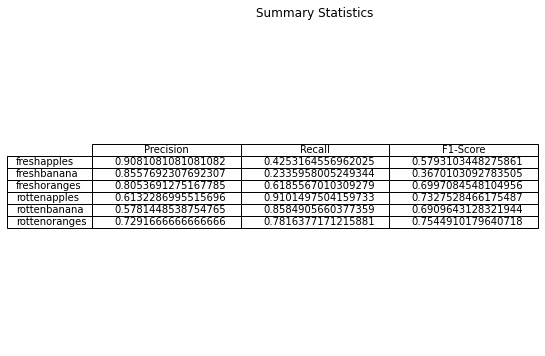

In [29]:
from sklearn.metrics import precision_recall_fscore_support

# Precision, Recall, F1-Score per Class
precision_per_class, recall_per_class, f1_score_per_class, _ = precision_recall_fscore_support(true_labels_encoded, predicted_labels_encoded, average=None)

# Set up the matplotlib figure
fig, axes = plt.subplots(figsize=(8, 6))

# Summary Statistics
summary_stats = pd.DataFrame({
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1-Score': f1_score_per_class
}, index=class_names)

axes.table(cellText=summary_stats.values, colLabels=summary_stats.columns, rowLabels=class_names, loc='center')
axes.axis('off')
axes.set_title('Summary Statistics')

plt.show()
